# 振子のパラメータ同定

In [1]:
import math
import copy
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import control
import datetime

from decimal import *
from control import tf, tfdata, matlab
from control.matlab import *
from scipy import signal
from scipy.integrate import odeint

from scipy.linalg import solve_continuous_are
from scipy.integrate import solve_ivp
import scipy.constants as cnst

from Modules import Modules
modules = Modules('')

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

print("OK\n")

OK



In [2]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y  

In [3]:
def calc_poly(df_value):
    #近似式の係数
    y = df_value
    res1=np.polyfit(x, y, 1)
    res2=np.polyfit(x, y, 2)
    res3=np.polyfit(x, y, 3)
    #近似式の計算
    y1 = np.poly1d(res1)(x) #1次
    y2 = np.poly1d(res2)(x) #2次
    y3 = np.poly1d(res3)(x) #3次
    
    #グラフ表示
    plt.scatter(x, y, label='元データ')
    plt.plot(x, y1, label='1次')
    plt.plot(x, y2, label='2次')
    plt.plot(x, y3, label='3次')
    plt.legend()
    plt.show()
    return y1,y2,y3

In [4]:
# 2次系伝達関数モデル作成の関数
def tf_2nd_order(zeta, wn):
   num = [math.pow(wn, 2)]
   den = [1, 2*zeta*wn, math.pow(wn, 2)]
   G = matlab.tf(num, den)
   return G

In [5]:
def get_peak(output, t):
    t_peak = 0
    a_max = 0
    for i, y in enumerate(output):
        if y > a_max:
            a_max = y
            t_peak = t[i]
    return a_max, t_peak

In [6]:
def calc_param_ab(a_max, t_peak, Kp, z_c):
    gumma_c = (1/t_peak) * math.log1p((z_c/a_max))
    delta_c = math.pi/t_peak
    omega_nc = math.sqrt(math.pow(gumma_c, 2) + math.pow(delta_c, 2))
    zeta_c = gumma_c/omega_nc
    print("omega_nc : " +str(omega_nc))
    print("zeta_c : " + str(zeta_c))
    a_m = 2 * zeta_c * omega_nc
    b_m = ((math.pow(omega_nc, 2))/Kp)
    return a_m, b_m

In [7]:
def plot_line(output, t, z_c, x_max, y_max):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.axhline(z_c, ls=":", color="blue")
    
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
    plt.title('2nd order step', fontsize=10)        # グラフタイトル
    plt.xlabel('time [sec]', fontsize=10)           # x軸ラベル
    plt.ylabel('Output', fontsize=10)               # y軸ラベル
    plt.xlim([0, x_max])                              # x軸範囲
    plt.ylim([0, y_max])                              # y軸範囲
    plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
    plt.tight_layout()                              # ラベルがきれいに収まるよう表示
    plt.grid()                                      # グリッド表示
    plt.show()    

<Axes: >

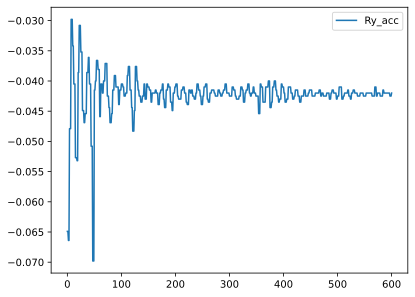

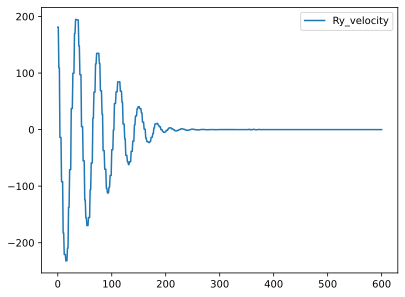

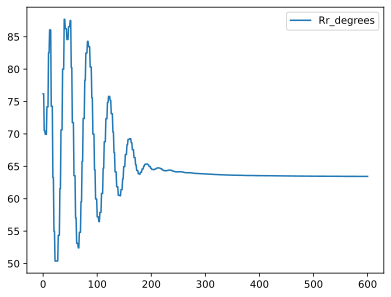

In [8]:
### サンプリング周波数200[Hz]で観測したデータ
#df = pd.read_csv('./param_ev3-005_1699278939.335626.tsv')
df = pd.read_csv('/home/uecadmin/researchScript/param_ev3-007_1699595979.0359282.tsv')
df.plot(y='Ry_acc')
df.plot(y='Ry_velocity')
df.plot(y='Rr_degrees')

In [9]:
df

,delta,Rx_acc,Rx_velocity,Rx_degrees,Ry_acc,Ry_velocity,Rr_degrees,Rz_acc,Rz_velocity,Rz_degrees
0,0.000016,-2.0093,-1.1597,-174.254,-0.0649,181.0913,76.196,0.7944,-1.7700,-77.173
1,0.035334,-2.0093,-1.1597,-174.254,-0.0649,181.0913,76.196,0.7944,-1.7700,-77.173
2,0.018833,-1.9619,1.6479,-175.754,-0.0664,109.2529,70.505,0.7285,-0.1831,-78.794
3,0.020597,-1.9619,1.6479,-175.754,-0.0664,109.2529,70.505,0.7285,-0.1831,-78.794
4,0.019508,-1.9077,0.3662,-175.710,-0.0479,-13.7939,69.939,0.6924,-1.7700,-78.799
...,...,...,...,...,...,...,...,...,...,...
596,0.018150,-1.9995,0.0000,-2.422,-0.0420,0.0000,63.446,0.9995,0.0000,100.311
597,0.018903,-2.0000,0.0000,-2.422,-0.0425,0.0000,63.446,0.9985,0.0000,100.311
598,0.018689,-2.0000,0.0000,-2.422,-0.0425,0.0000,63.446,0.9985,0.0000,100.311
599,0.018702,-2.0000,0.0000,-2.422,-0.0425,0.0000,63.446,0.9985,0.0000,100.311


In [10]:
time = 0
TimeSeries = []
for index, row in df.iterrows():
    if index == 0:
        TimeSeries.append(0)
    else:
        TimeSeries.append(TimeSeries[index - 1] + row['delta'])
    time = time + row['delta']
samplerate = 1.0 / (time / 600)
endtime = time

In [11]:
endtime

11.541357517242428

## 振り子の自由振動/減衰系のシュミレーション

In [12]:
### 実験結果からパラメータを取得
velocity = df['Ry_velocity'].values
degrees = df['Rr_degrees'].values
max_degress = max(degrees)
min_degress = min(degrees)
last_degrees = degrees[600]
offset = last_degrees
print(max_degress - last_degrees)
print(last_degrees - min_degress)
print(max_degress - min_degress)

24.251999999999995
13.062999999999995
37.31499999999999


In [13]:
### 振り子の自由振動
def wave_sym(t, v, zeta_p, omgega_np, theta_0, offset):
    omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))
    deg = (np.exp(- zeta_p * omgega_np * t) * (np.cos(omega_dp * t) + (zeta_p/np.sqrt(1 - np.power(zeta_p, 2) * np.sin(omega_dp * t)))) * theta_0) + offset
    # sol[0]が変位x1, sol[1]が速度x2となる
    #return [deg, v]
    return deg

In [14]:
len(velocity)

601

24.251999999999995


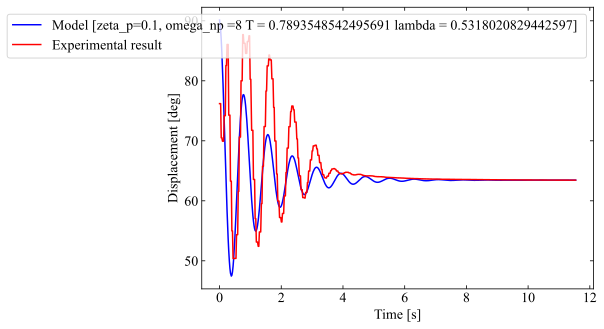

In [15]:
### 実験結果とサンプリング周波数,タイムスケールを同期させたシミュレート
t0 = TimeSeries[0]
t = TimeSeries
time = TimeSeries
zeta_p = 0.10
omgega_np = 8
theta_0 = max_degress - last_degrees
print(theta_0)
sol = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    sol.append(wave_sym(time[index], velocity[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

# ---------------------------------------------------------------------- #
# グラフ描画
# ---------------------------------------------------------------------- #
# フォントの種類とサイズを設定
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# 目盛を設定
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

# 軸のラベルを設定する。
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Displacement [deg]')

# データプロット
## 計算値
ax1.plot(time, sol, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='b')
## 実験結果
ax1.plot(TimeSeries, df['Rr_degrees'].values, label='Experimental result', c='r')

fig.tight_layout()
plt.legend(loc='upper right')

# グラフを表示する。
plt.show()
plt.close()

In [16]:
len(sol)

601

In [17]:
### 振り子の自由振動
def wave_sym2(t, zeta_p, omgega_np, theta_0, offset):
    omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))
    deg = (np.exp(- zeta_p * omgega_np * t) * (np.cos(omega_dp * t) + (zeta_p/np.sqrt(1 - np.power(zeta_p, 2) * np.sin(omega_dp * t)))) * theta_0)
    return deg

0.7893548542495691
0.5318020829442597


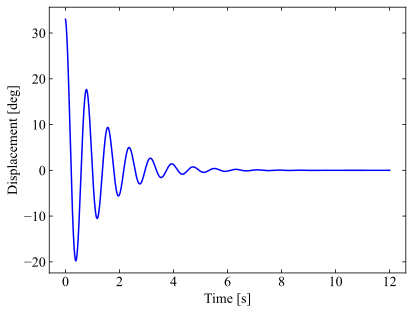

In [18]:
### データポイントを増やしてシミュレート
t0 = 0
et = 12
dt = 0.001
time = np.arange(t0, (et+dt), dt)
theta_0 = 30

# ---------------------------------------------------------------------- #
# mode 01
# ---------------------------------------------------------------------- #
zeta_p = 0.1
omgega_np = 8
mode1 = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    mode1.append(wave_sym2(time[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))
print(T)
print(lamb)

# ---------------------------------------------------------------------- #
# データプロット
# ---------------------------------------------------------------------- #
# フォントの種類とサイズを設定
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# 目盛を設定
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

# 軸のラベルを設定する。
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Displacement [deg]')
ax2.plot(time, mode1, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='b')

# ---------------------------------------------------------------------- #
# mode 02
# ---------------------------------------------------------------------- #
zeta_p = 0.2
omgega_np = 10
theta_0 = max_degress - last_degrees
mode2 = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    mode2.append(wave_sym2(time[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

# ---------------------------------------------------------------------- #
# データプロット
# ---------------------------------------------------------------------- #
## 計算値
#ax2.plot(time, mode2, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='g')


# グラフを表示する。
plt.show()
plt.close()

## モータの角加速度を制御する

### 最適レギュレータによるゲイン導出

In [20]:
### パラメータ導出
am = 8.272856311536618
bm = 2.4549525908389445

g = 9.81     # 重力加速度
M = 0.75     # 振子の質量
m = 0.15    # タイヤの質量
lp = 0.08    # 重心位置から車軸の距離
Kv = 1.0
r_omega = 0.026
#### 周期T,減衰率λ
zeta_p = 0.2
omgega_np = 8

# ωdp
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# Tpeak
T_peak = (2 * math.pi)/omega_dp
# λ
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

#### γ,δp
gumma_p = (1/T_peak) * np.log(1/lamb)
delta_p = (2 * math.pi) / T_peak
#### ωnp,ζp
omega_np = np.sqrt(np.power(gumma_p, 2) + np.power(delta_p, 2))
print('ωnp : ' + str(omega_np))
zeta_p = gumma_p/omega_np

#### (I + J + m・r^2_ω + M・lp^2 + 2Mlpr_ω)
param1 = (M * g * lp)/np.power(omega_np, 2)

#### μp
mu_p = -2 * omega_np * zeta_p * param1

# α,β
alpha = np.power(omega_np, 2)/Kv

beta = (-1 * mu_p) / param1

#J,(J + mrω^2 + Mrω^2 + Mlprω)
J = (M * g * lp)/np.power(omega_np, 2) - (M * np.power(lp, 2))
param2 = J + (m * np.power(r_omega, 2)) + (M * np.power(r_omega, 2)) + (M * lp * r_omega)

# gumma
gumma = (am * param2)/param1
delta = (-bm * param2)/param1

print('α : ' + str(alpha))
print('β : ' + str(beta))
print('γ : ' + str(gumma))
print('δ : ' + str(delta))

### 最適レギュレータ

A = [[0, 1, 0, 0]
     ,[alpha, beta, 0, gumma]
     ,[0, 0, 0, 1]
     ,[0, 0, 0, -am]]
B = [[0]
    ,[delta]
    ,[0]
    ,[bm]]
Q = [[10, 0, 0, 0]
    ,[0, 1, 0, 0]
    ,[0, 0, 100, 0]
    ,[0, 0, 0, 100]]
# 4x4の単位行列を生成
C = np.eye(4)
# 4x1の零行列を生成
D = np.zeros([4, 1])


P = ss(A, B, C, D)
R = 100000000
F,X,E = lqr(P.A, P.B, Q, R)
F = -F

print('---- フィードバックゲイン ----')
print(F)
print(-(1/R) * P.B.T * X)

print('---- 閉ループ系 ----')
print(E)
print(np.linalg.eigvals(A + B * F))

ωnp : 8.0
α : 64.0
β : 3.1999999999999997
γ : 5.9056556407174785
δ : -1.7524908048462275
---- フィードバックゲイン ----
[[1.34962763e+02 2.05785131e+01 9.99999032e-04 6.74005069e+00]]
[[1.34962763e+02 2.05785131e+01 9.99999032e-04 6.74005069e+00]]
---- 閉ループ系 ----
[-9.75842183e+00 -8.27285666e+00 -6.55843122e+00 -2.96747868e-04]
[-9.75842183e+00 -8.27285666e+00 -6.55843122e+00 -2.96747868e-04]


#### ゲインを適用しない場合

True

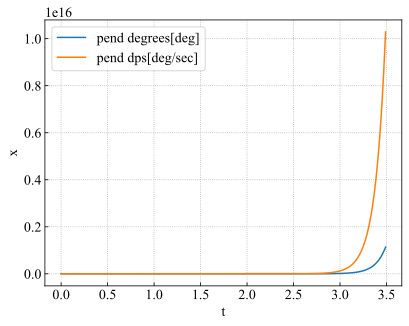

In [21]:
# 状態フィードバックゲインなし
Acl = P.A + P.B 
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 3.5, 0.01)
X0 = [24, velocity[0], 0, 0]

x, t = initial(Pfb, Td, X0)

fig, ax = plt.subplots()
ax.plot(t, x[:,0], label = 'pend degrees[deg]')
ax.plot(t, x[:,1], label = 'pend dps[deg/sec]')
modules.plot_set(ax, 't', 'x', 'best')

#### ゲインを適用する場合

True

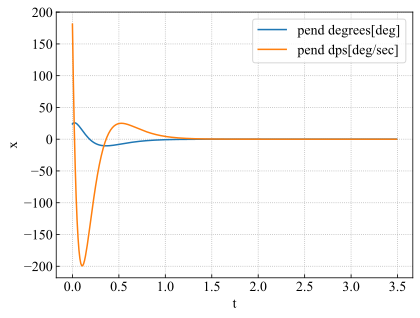

In [22]:
# 最適レギュレータにより導出した状態フィードバックゲインを適用する
#dps_a = df_motor['dps_a'].values
#a_position = df_motor['a_position'].values
#pos = a_position[1]/360

Acl = P.A + P.B*F 
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 3.5, 0.01)
X0 = [24, velocity[0], 0, 0]

x, t = initial(Pfb, Td, X0)

fig, ax = plt.subplots()
ax.plot(t, x[:,0], label = 'pend degrees[deg]')
ax.plot(t, x[:,1], label = 'pend dps[deg/sec]')
#ax.plot(t, x[:,2], label = 'motor degrees[deg]')
#ax.plot(t, x[:,3], label = 'motor dps[deg/sec]')
modules.plot_set(ax, 't', 'x', 'best')

In [23]:
### 可制御性の確認 
Uc = ctrb(P.A, P.B)
print('Uc=\n', Uc)
print('det(Uc)=', np.linalg.det(Uc))
print('rank(Uc)=', np.linalg.matrix_rank(Uc))

Uc=
 [[    0.            -1.7524908      8.89013404  -203.65171886]
 [   -1.7524908      8.89013404  -203.65171886   909.53555535]
 [    0.             2.45495259   -20.30947004   168.01732737]
 [    2.45495259   -20.30947004   168.01732737 -1389.98320717]]
det(Uc)= 75815.44057281943
rank(Uc)= 4


In [24]:
# Controllability
Wc = ctrb(P.A, P.B)
a = np.mat(P.A)
print("Wc = ", Wc)
if np.linalg.matrix_rank(Wc) != a.shape[0]:
   print ("System not Controllability\n")
else :
   print ("System Controllability\n")

Wc =  [[    0.            -1.7524908      8.89013404  -203.65171886]
 [   -1.7524908      8.89013404  -203.65171886   909.53555535]
 [    0.             2.45495259   -20.30947004   168.01732737]
 [    2.45495259   -20.30947004   168.01732737 -1389.98320717]]
System Controllability



#### 自由振動パラメータ同定に用いたモデルの検証

In [25]:
P = control.tf([0, alpha * Kv], [1, beta, alpha * Kv])
print(f"自由振動パラメータ同定に用いたモデルの伝達関数\n{P}\n")

自由振動パラメータ同定に用いたモデルの伝達関数

       64
----------------
s^2 + 3.2 s + 64




### PID制御器の検討

In [26]:
am = 8.272856311536618
bm = 2.4549525908389445
a1 = bm
a2 = (gumma + am) * bm
b1 = (am - beta)
b2 = - (am * beta + alpha)
b3 = - (am * alpha)
print('a1 : ' + str(a1))
print('b1 : ' + str(b1))
print('b2 : ' + str(b2))
print('b3 : ' + str(b3))
bm*gumma

a1 : 2.4549525908389445
b1 : 5.0728563115366185
b2 : -90.47314019691717
b3 : -529.4628039383435


14.498104615782001

In [27]:
### パラメータ定義
am = 16.05891389967057
bm = 11.164284779591377
g = 9.81     # 重力加速度
M = 0.94     # 振子の質量
m = 0.15    # タイヤの質量
lp = 0.08    # 重心位置から車軸の距離


Np = [a1, a2]
Dp = [1, b1, b2, b3]

P = control.tf(Np, Dp)
P

TransferFunction(array([ 2.45495259, 34.80757465]), array([   1.        ,    5.07285631,  -90.4731402 , -529.46280394]))

True

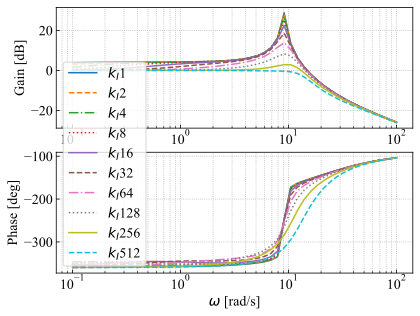

In [28]:
# 目標値
ref = 90

Kp = 40
Kd = 2
Ki = (1, 2, 4, 8, 16, 32, 64, 128, 256, 512)

LS = modules.linestyle_generator()
fig,ax = plt.subplots(2, 1)
for i in range(len(Ki)):
    K = control.tf([Kd, Kp, Ki[i]], [1, 0])
    Gyr = feedback(P*K, 1)
    gain, phase, w = bode(Gyr, logspace(-1, 2), plot=False)
    
    pltargs = {'ls': next(LS), 'label': '$k_I$'+str(Ki[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
modules.bodeplot_set(ax, 'best')

True

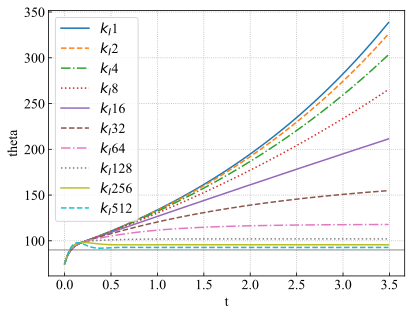

In [29]:
LS = modules.linestyle_generator()
fig,ax = plt.subplots()
for i in range(len(Ki)):
    K = control.tf([Kd, Kp, Ki[i]], [1])
    Gyr = feedback(P*K, 1)
    y, t = step(Gyr, np.arange(0, 3.5, 0.01))
    pltargs = {'ls': next(LS), 'label': '$k_I$'+str(Ki[i])}
    ax.plot(t, y*ref, **pltargs)
ax.axhline(ref, color="k", linewidth=0.5)
modules.plot_set(ax, 't', 'theta', 'best')